# Clustering based on EC-ERA5

In this notebook, we perform clustering based on the the PCA results of EC-ERA5 dataset. 

**Note:**
In the earlier test, we see strange time series of the PCA projections, and hence we re-do the PCA without incremental steps. And then we found the visualization looked erroneous is because of the *matplotlib.pyplot* treat the date as large integers, and auto-filled the gap between \[YYYY\]-12-31 and \[YYYY+1\]-01-01 with interpolations. We re-designed the visualization code and fixed the problem.


## Dataset

The dataset we used includes 16 characteristic levels, namely: *sea level pressure, geopotential at 500hPa, u and v at 200hPa, and (u, v, T, q) at 925, 850, and 700 hPa*. The EC-ERA5 dataset is 0.25 degree interval, and the domain we analyzed is: 100 - 140 E / 10 - 50 N.

## Read PCA projection

(14607, 20)
Index(['mslp_pc1', 'mslp_pc2', 'mslp_pc3', 'mslp_pc4', 'mslp_pc5', 'mslp_pc6',
       'mslp_pc7', 'mslp_pc8', 'mslp_pc9', 'mslp_pc10', 'mslp_pc11',
       'mslp_pc12', 'mslp_pc13', 'mslp_pc14', 'mslp_pc15', 'mslp_pc16',
       'mslp_pc17', 'mslp_pc18', 'mslp_pc19', 'mslp_pc20'],
      dtype='object')


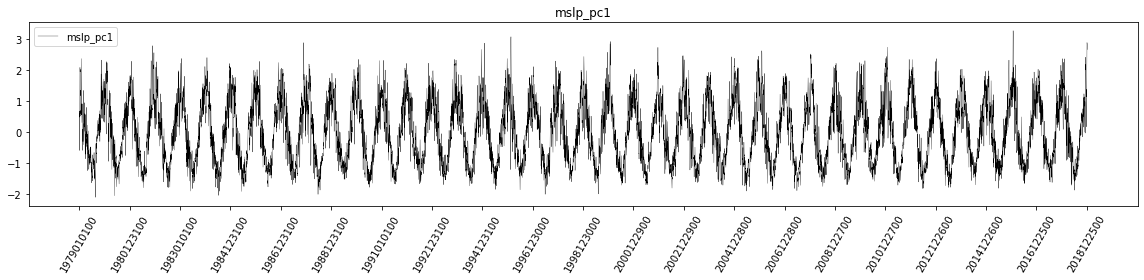

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Defined Parameters
PROJPATH = '../data/pca_era5/projection/'
PROJSUFFIX = '.proj.csv'
LAYERS = ['mslp', 'q925','t925','u925','v925','q850','t850','u850','v850','q700','t700','u700','v700','h500','u200','v200']

def read_20_pcs(fname, varname=''):
    ''' Read PCs from specified file.'''
    import pandas as pd
    import numpy as np
    data = pd.read_csv(fname, index_col=0)
    data = data.iloc[:,:20]
    data.columns = [varname+"_pc"+str(i+1) for i in range(20)]
    return(data)

tmp = read_20_pcs('../data/pca_era5/projection/mslp.proj.csv', varname='mslp')

print(tmp.shape)
print(tmp.columns)

plt.figure(figsize=(16,4))
plt.plot(list(tmp['mslp_pc1']), color='black', ls='solid', lw=0.3, label='mslp_pc1')
plt.xticks(np.arange(0, tmp.shape[0], step=int(tmp.shape[0]/20)), tmp.index[np.arange(0, tmp.shape[0], step=int(tmp.shape[0]/20))], rotation=60)
plt.title('mslp_pc1')
plt.legend()
plt.tight_layout()
plt.show()

## Aggregation of 16 CLs



In [2]:
# Define all fields to read
PROJPATH = '../data/pca_era5/projection/'
PROJSUFFIX = '.proj.csv'
LAYERS = ['mslp', 'q925','t925','u925','v925','q850','t850','u850','v850','q700','t700','u700','v700','h500','u200','v200']
# Read MLSP
data = read_20_pcs(PROJPATH+LAYERS[0]+PROJSUFFIX, LAYERS[0])
# Read and merge all layers
for l in LAYERS[1:]:
    fname = PROJPATH+l+PROJSUFFIX
    tmp = read_20_pcs(fname, varname=l)
    data = data.merge(tmp, left_index=True, right_index=True, suffixes=("",""))

print(data.shape)
print(data.columns)

(14607, 320)
Index(['mslp_pc1', 'mslp_pc2', 'mslp_pc3', 'mslp_pc4', 'mslp_pc5', 'mslp_pc6',
       'mslp_pc7', 'mslp_pc8', 'mslp_pc9', 'mslp_pc10',
       ...
       'v200_pc11', 'v200_pc12', 'v200_pc13', 'v200_pc14', 'v200_pc15',
       'v200_pc16', 'v200_pc17', 'v200_pc18', 'v200_pc19', 'v200_pc20'],
      dtype='object', length=320)


## Illustrate the Time Series of PC1 of Each CL

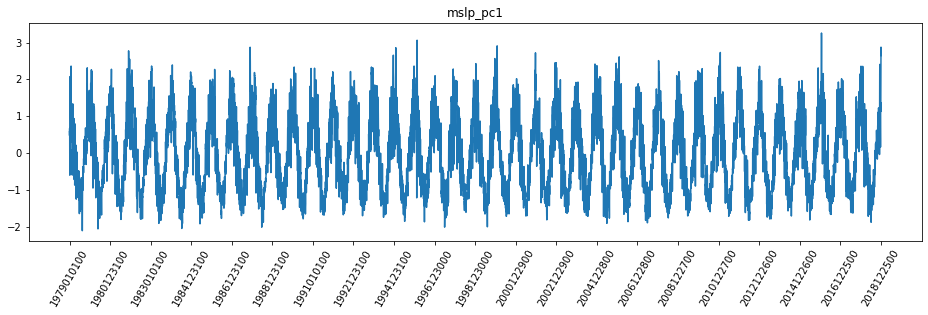

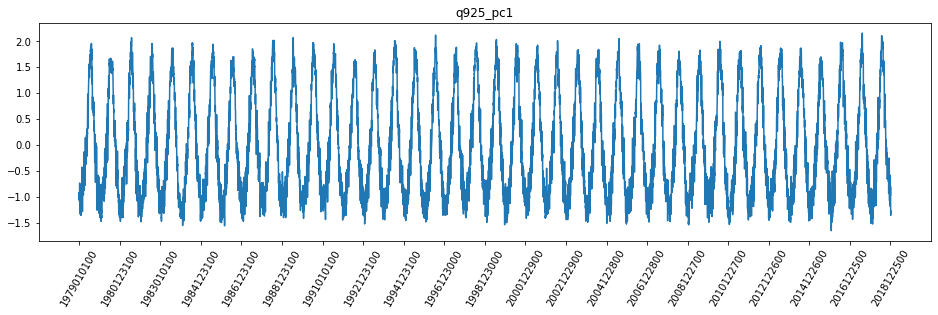

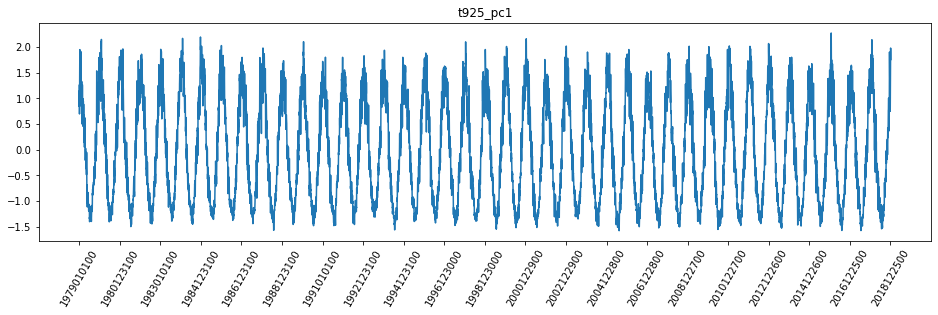

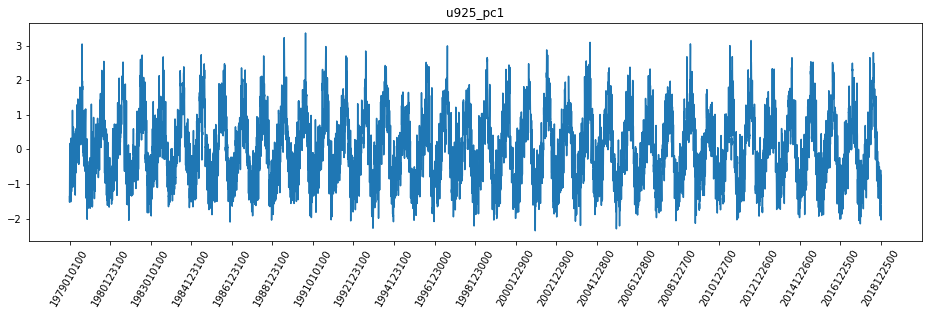

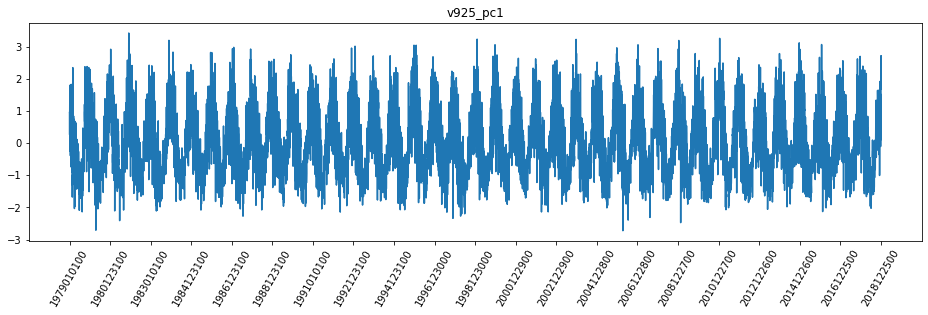

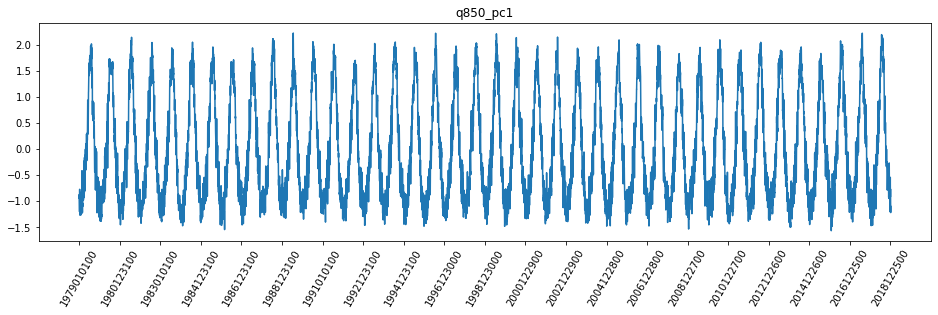

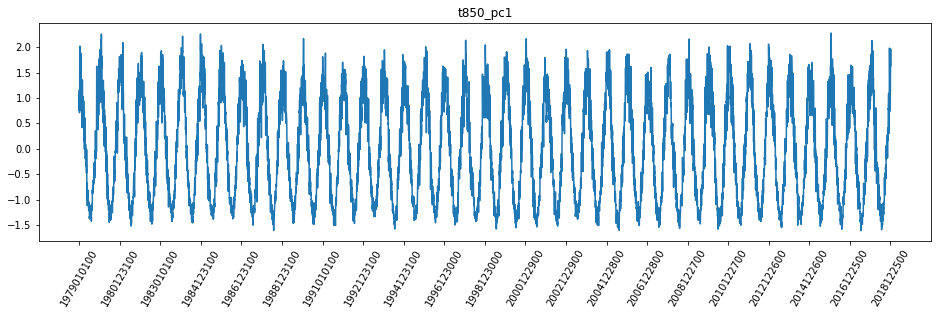

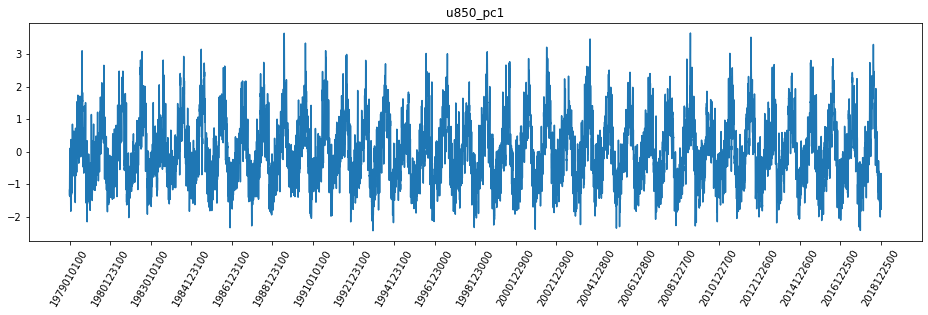

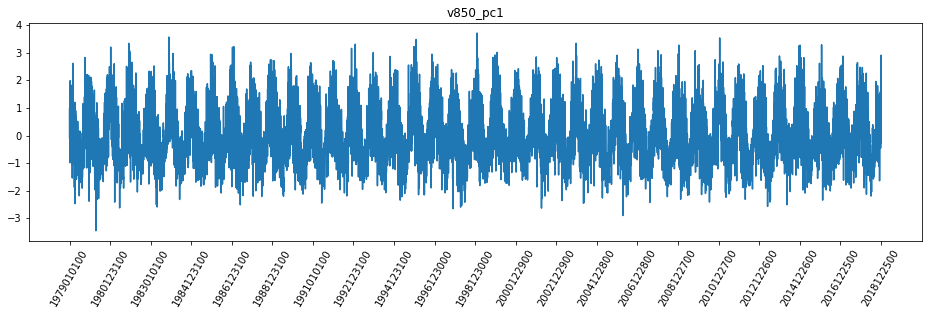

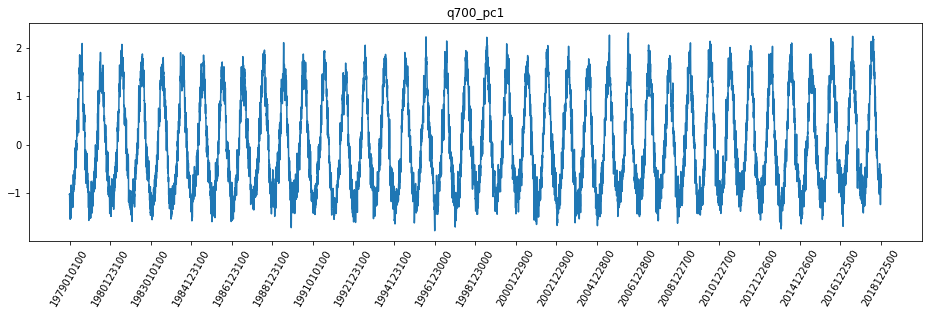

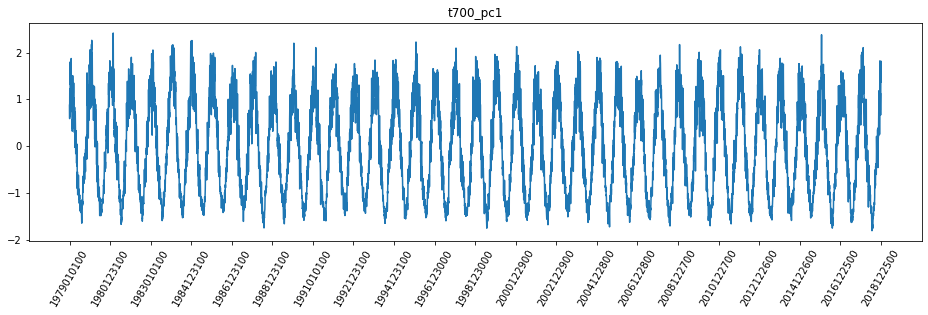

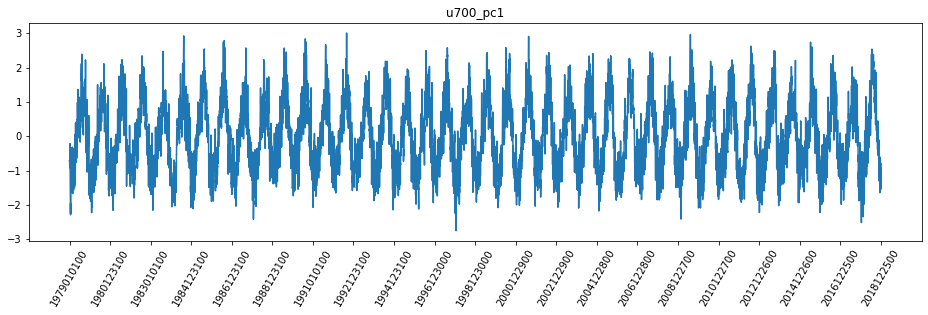

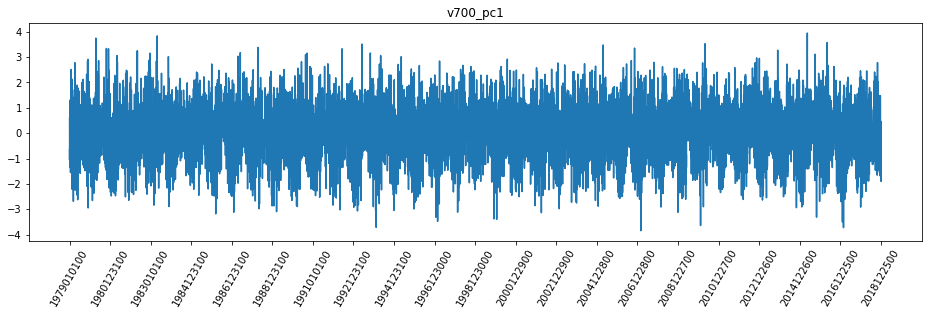

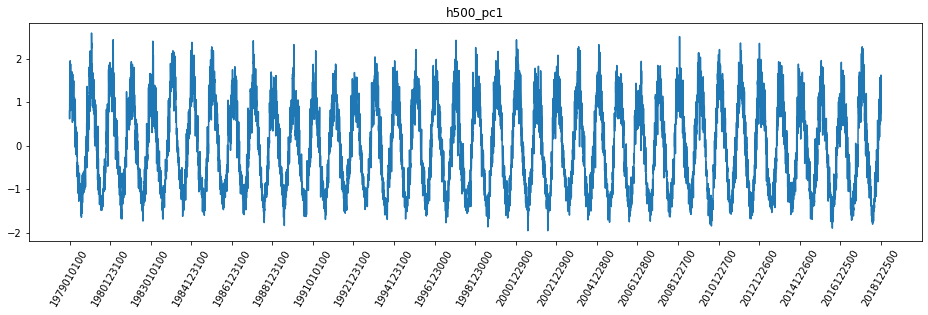

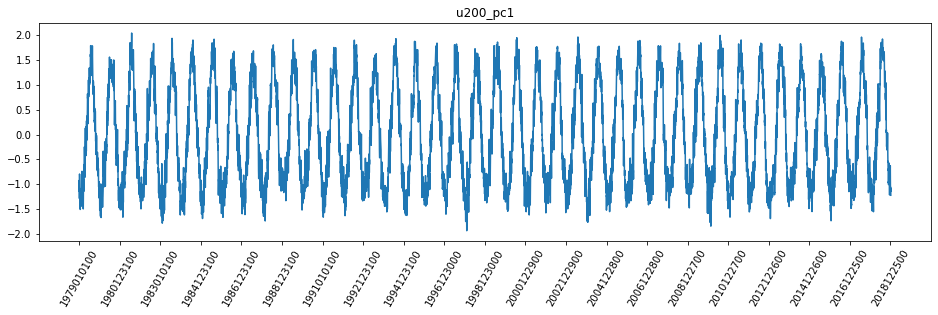

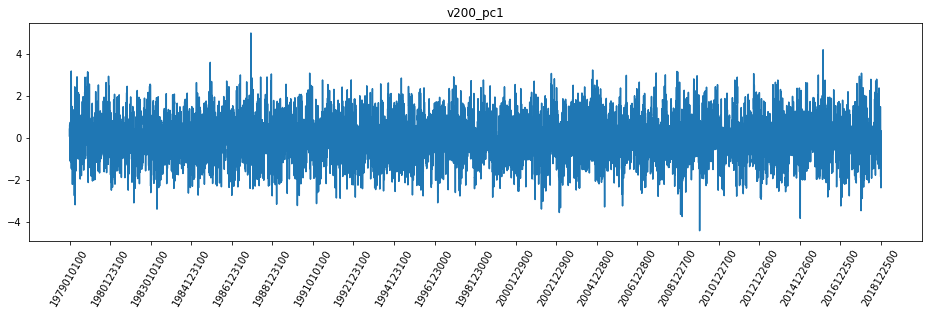

In [3]:
for l in LAYERS:
    tmp = data[l+'_pc1']
    plt.figure(figsize=(16,4))
    plt.plot(list(tmp))
    plt.xticks(np.arange(0, data.shape[0], step=int(data.shape[0]/20)), data.index[np.arange(0, data.shape[0], step=int(tmp.shape[0]/20))], rotation=60)
    plt.title(l+'_pc1')
    plt.show()

From the evolutions of 16 characteristic levels in the past 40 years, we did not see a clear trend. Therefore it should be safe to use a shorter time period for clustering.

We will proceed with some testing:
1. Use the latest $N$ years for clustering, $C$.
2. Use $C$ to label the earlier years.
3. Check the stability of the clustering results.

Let's try $N$ = 1, 3, 5, 10.

In [4]:
ts = list(data.index)
print('Total days: ' + str(len(ts)))
print('Last date: ' + str(ts[-1]))
print('Entry of 2018010100: ' + str(ts.index(2018010100)))
print('Entry of 2016010100: ' + str(ts.index(2016010100)))
print('Entry of 2014010100: ' + str(ts.index(2014010100)))
print('Entry of 2009010100: ' + str(ts.index(2009010100)))

Total days: 14607
Last date: 2018123100
Entry of 2018010100: 14242
Entry of 2016010100: 13511
Entry of 2014010100: 12781
Entry of 2009010100: 10955


The following parameters were tested against the PCA results with the `whiten=True`. For parameters used for hierarchical clustering, please see the reference of [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) and [dengrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

Data dimension: (365, 320)


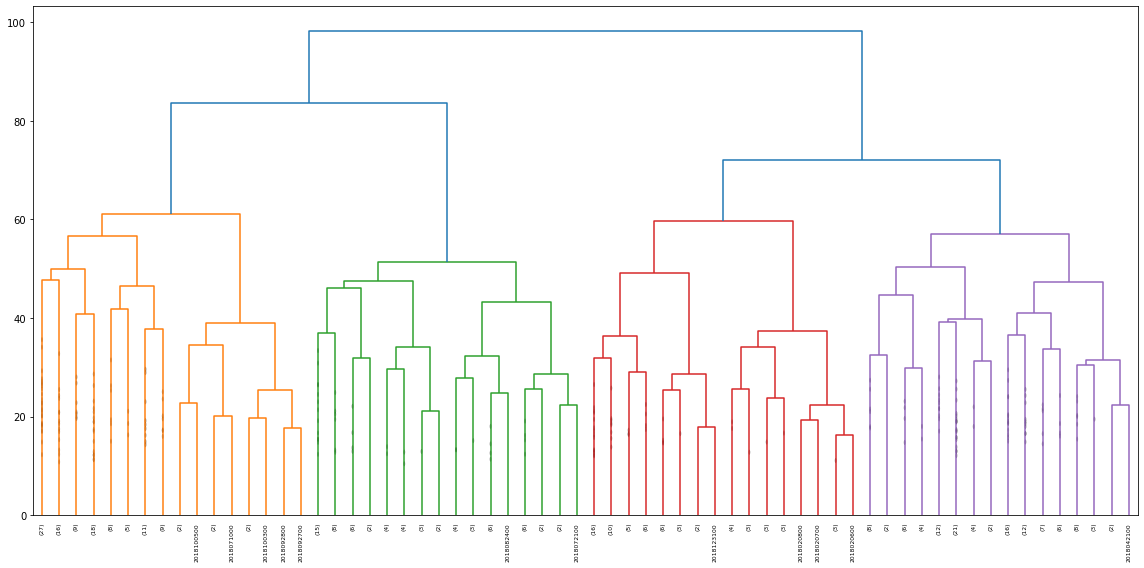

In [5]:
# 1 Year

tmp = data.iloc[14242:,:]
print("Data dimension: "+str(tmp.shape))

from scipy.cluster.hierarchy import dendrogram, linkage  

linked = linkage(tmp, 'ward')
labelList = tmp.index

plt.figure(figsize=(16, 8))  
dendrogram(linked,
            truncate_mode='level', # show only the last p merged clusters
            p=5,                  # show only the last p merged clusters
            show_contracted=True,  # to get a distribution impression in truncated branches
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.tight_layout()
plt.show()

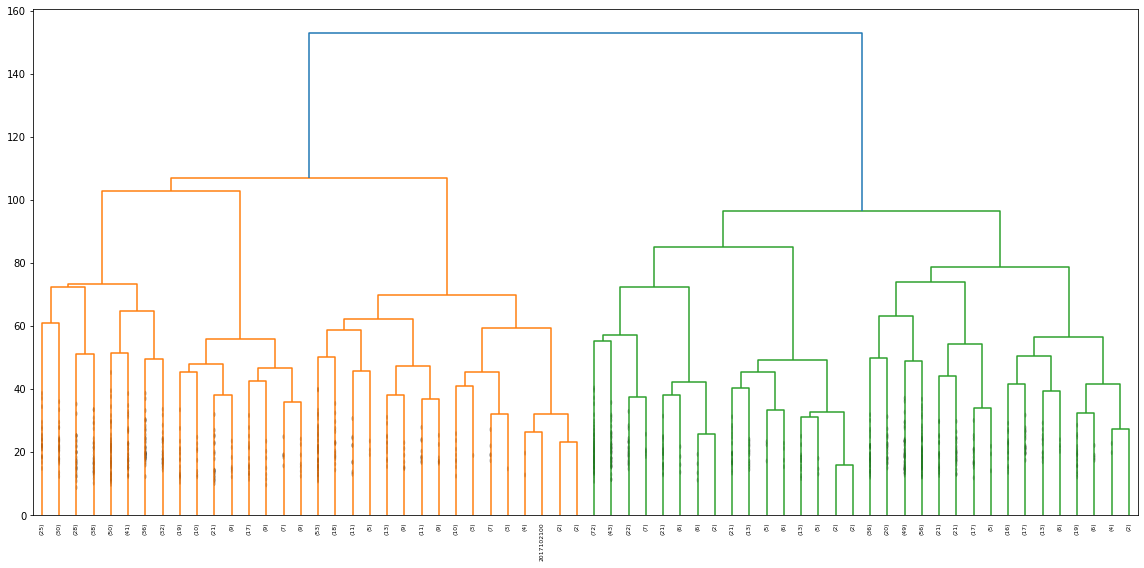

In [6]:
# 3 Year

tmp = data.iloc[13511:,:]

from scipy.cluster.hierarchy import dendrogram, linkage  

linked = linkage(tmp, 'ward')
labelList = tmp.index

plt.figure(figsize=(16, 8))  
dendrogram(linked,
            truncate_mode='level', # show only the last p merged clusters
            p=5,                  # show only the last p merged clusters
            show_contracted=True,  # to get a distribution impression in truncated branches
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.tight_layout()
plt.show()

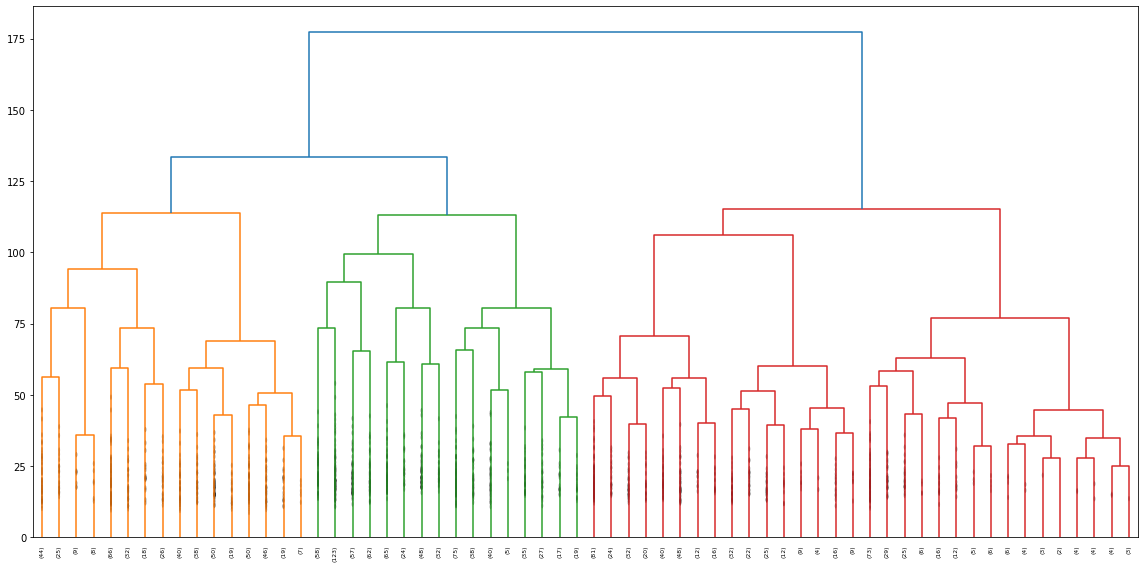

In [7]:
# 5 Year

tmp = data.iloc[12781:,:]

from scipy.cluster.hierarchy import dendrogram, linkage  

linked = linkage(tmp, 'ward')
labelList = tmp.index

plt.figure(figsize=(16, 8))  
dendrogram(linked,
            truncate_mode='level', # show only the last p merged clusters
            p=5,                  # show only the last p merged clusters
            show_contracted=True,  # to get a distribution impression in truncated branches
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.tight_layout()
plt.show()

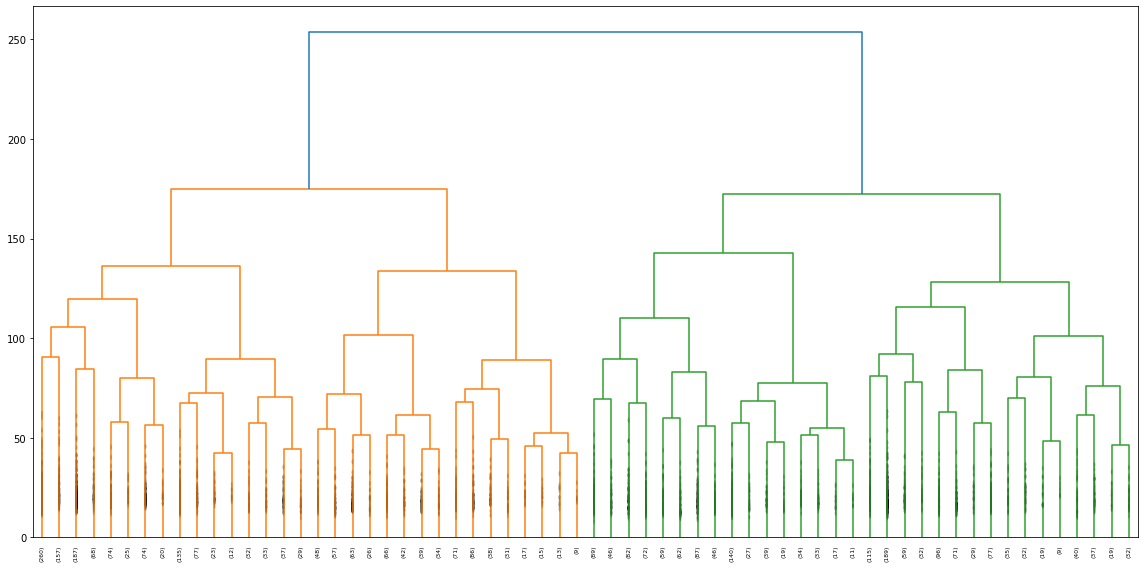

In [8]:
# 10 Year

tmp = data.iloc[10955:,:]

from scipy.cluster.hierarchy import dendrogram, linkage  

linked = linkage(tmp, 'ward')
labelList = tmp.index

plt.figure(figsize=(16, 8))  
dendrogram(linked,
            truncate_mode='level', # show only the last p merged clusters
            p=5,                  # show only the last p merged clusters
            show_contracted=True,  # to get a distribution impression in truncated branches
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.tight_layout()
plt.show()

Using PCA with correlation matrix requires the **ward** distance to give good results. Other distance measures always resulting in 'adding instance one-by-one'. Next, we will check the clusters and see the exmplars.